<h2 align="center">Codebasics DL Course: Transfer Learning</h2>

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Caltech101 Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),       # Randomly flip images horizontally
    transforms.RandomRotation(10),           # Randomly rotate images    
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to range [-1, 1]
])

# Load the entire dataset
dataset = datasets.ImageFolder(root='./images', transform=transform)

In [4]:
len(dataset)

9144

In [5]:
dataset.classes

['BACKGROUND_Google',
 'Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [6]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(7315, 1829)

In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Visualize a Few Images

In [26]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


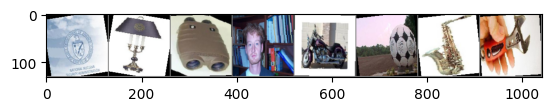

In [31]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:8]))

In [32]:
labels[:8]

tensor([  0,  57,  12,   1,   4,  85,  79, 100])

In [33]:
[dataset.classes[i] for i in labels[:8]]

['BACKGROUND_Google',
 'lamp',
 'binocular',
 'Faces',
 'Motorbikes',
 'soccer_ball',
 'saxophone',
 'wrench']

### Model Training Without Transfer Learning

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=(3,3), padding="same"), # output (32, 128, 128)
            nn.ReLU(), 
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), # output (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=(3,3), padding="same"), # output (64, 64, 64)
            nn.ReLU(), 
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)),  # output (64, 32, 32)
            
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),            
            nn.Linear(128, num_classes) 
        )
    
    def forward(self, x):
        return self.network(x)

In [22]:
# Training loop
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [23]:
# Initialize model, loss function, and optimizer
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)        

Epoch [1/5], Loss: 3.3749
Epoch [2/5], Loss: 2.4998
Epoch [3/5], Loss: 2.0209
Epoch [4/5], Loss: 1.6777
Epoch [5/5], Loss: 1.4410


In [24]:
def test_model(model, test_loader):
    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    
test_model(model, test_loader)    

Test Accuracy: 51.28%


### Model Training With Transfer Learning

In [43]:
num_classes

102

### ResNet 18

In [25]:
from torchvision import models

# Load pre-trained ResNet18 model
model = models.resnet18(weights='DEFAULT')

# Replace the fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)   
test_model(model, test_loader)  

Epoch [1/5], Loss: 2.0362
Epoch [2/5], Loss: 1.0620
Epoch [3/5], Loss: 0.7520
Epoch [4/5], Loss: 0.5675
Epoch [5/5], Loss: 0.4453
Test Accuracy: 78.18%


In [25]:
from torchvision import models

# Load pre-trained ResNet18 model
model = models.resnet18(weights='DEFAULT')

# Replace the fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)   
test_model(model, test_loader)  

Epoch [1/5], Loss: 2.0362
Epoch [2/5], Loss: 1.0620
Epoch [3/5], Loss: 0.7520
Epoch [4/5], Loss: 0.5675
Epoch [5/5], Loss: 0.4453
Test Accuracy: 78.18%


### EfficientNet

In [35]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)   
test_model(model, test_loader)  

Epoch [1/5], Loss: 1.4747
Epoch [2/5], Loss: 0.5423
Epoch [3/5], Loss: 0.3522
Epoch [4/5], Loss: 0.2643
Epoch [5/5], Loss: 0.2264
Test Accuracy: 87.26%
